# **Importing Necessary Libraries**
**matplotlib** -> Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python. 

**tensorflow** ->  It can be used across a range of tasks but has a particular focus on training and inference of deep neural networks

**tensorflow_io** -> TensorFlow I/O is a collection of file systems and file formats that are not available in TensorFlow's built-in support. It provides useful extra Dataset, streaming, and file system extensions

In [10]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# Define path for the data

In [11]:
CAPUCHIN_FILE = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC3776-3.wav'
NOT_CAPUCHIN_FILE = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

In [12]:
NOT_CAPUCHIN_FILE

'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/afternoon-birds-song-in-forest-0.wav'

# Data Loading Function
The below "load_wav_16k_mono" function take filename as an input and convert to 16000hz single channel

In [13]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [14]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

# Plot Wave
Blue -> positive samples ||
Orange -> Negative samples

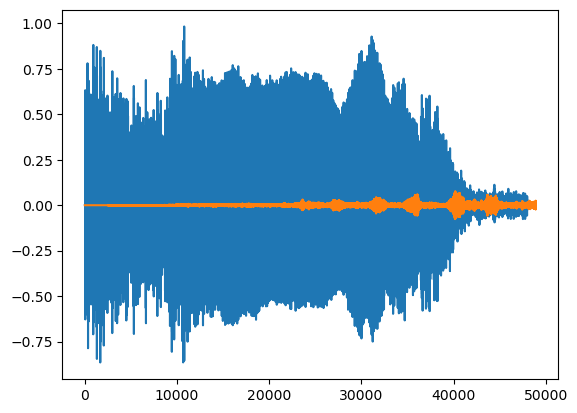

In [15]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create Tensorflow Dataset

Define paths for all data's

In [16]:
POS = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'
NEG = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips'

In [17]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

In [18]:
pos.as_numpy_iterator().next()

b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC433953-1.wav'

In [19]:
len(pos)

217

In [20]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [21]:
positives.as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC27882-6.wav',
 1.0)

In [22]:
data.shuffle(1000).as_numpy_iterator().next()

(b'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC3776-1.wav',
 1.0)

In [ ]:
os.listdir(POS)

In [24]:
lengths = []
for file in os.listdir(POS):
    tensor_wave = load_wav_16k_mono(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [25]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [26]:
54156/16000 # avg(seconds) bird call in data [mean_value/16000 per cycle] 

3.38475

In [27]:
tf.math.reduce_min(lengths) 

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [28]:
# min seconds bird sound in data
32000/16000

2.0

In [29]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [30]:
# max seconds bird sound in data
80000/16000

5.0

In [31]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [32]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [33]:
spectrogram, label = preprocess(filepath, label)

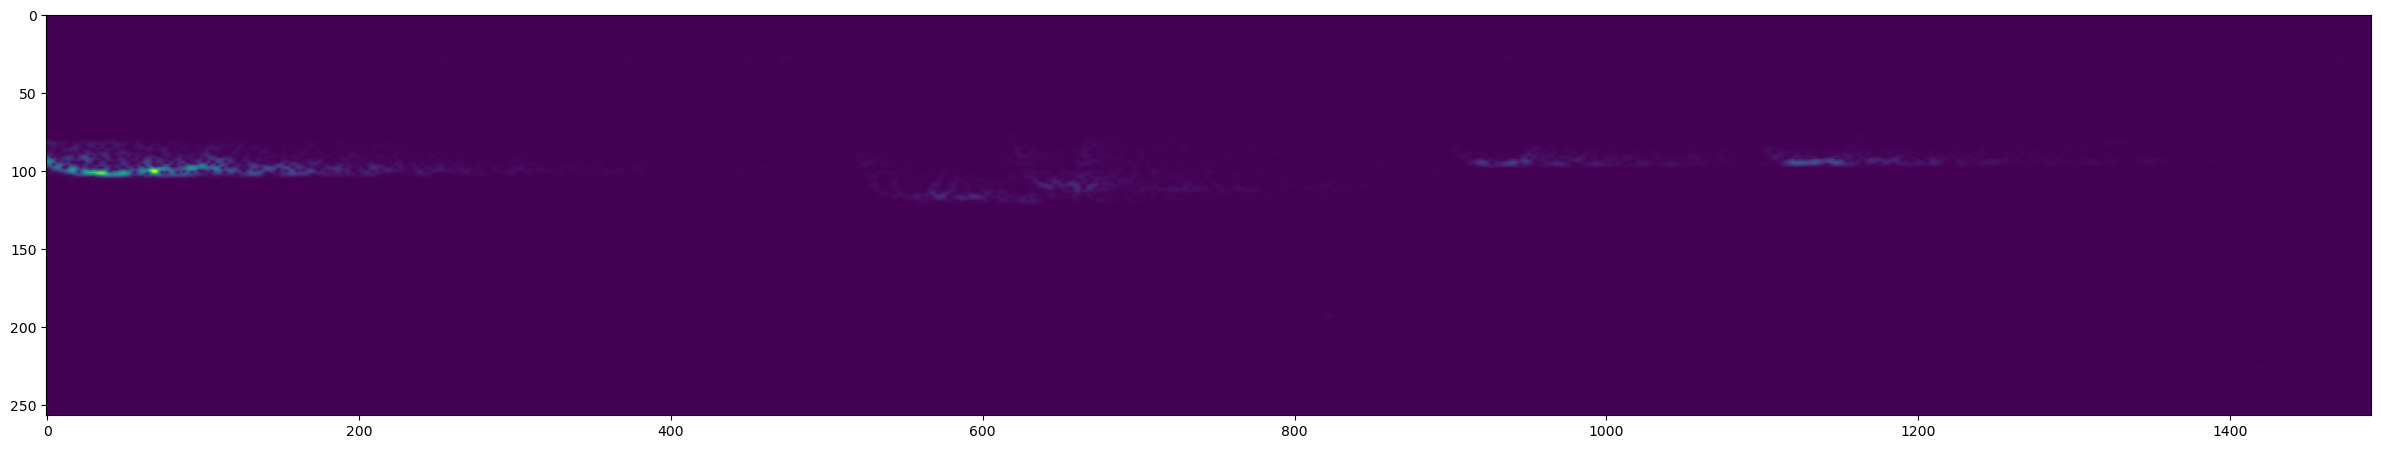

In [34]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [35]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [36]:
train = data.take(36)
test = data.skip(36).take(15)

In [37]:
samples, labels = train.as_numpy_iterator().next()

In [38]:
samples.shape

(16, 1491, 257, 1)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [40]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [41]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [42]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 6019376)           0         
                                                                 
 dense (Dense)               (None, 128)               770480256 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [43]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 [==============================] - 301s 8s/step - loss: 7.5850 - recall: 0.8784 - precision: 0.8228 - val_loss: 0.7822 - val_recall: 1.0000 - val_precision: 0.8904
Epoch 2/4
36/36 [==============================] - 317s 9s/step - loss: 0.1386 - recall: 0.9419 - precision: 0.9605 - val_loss: 0.0269 - val_recall: 0.9841 - val_precision: 0.9841
Epoch 3/4
36/36 [==============================] - 522s 15s/step - loss: 0.0125 - recall: 0.9932 - precision: 0.9932 - val_loss: 0.0244 - val_recall: 0.9839 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 419s 12s/step - loss: 0.0061 - recall: 0.9864 - precision: 1.0000 - val_loss: 0.0059 - val_recall: 1.0000 - val_precision: 1.0000


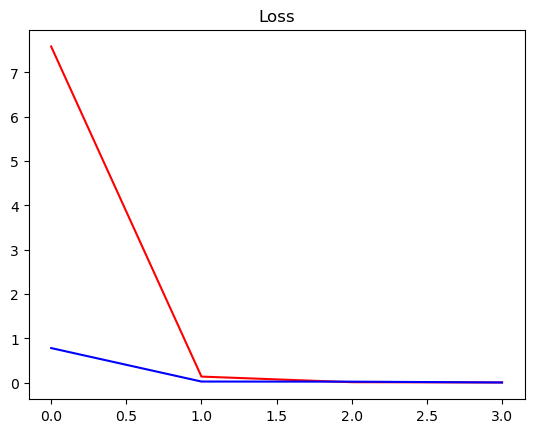

In [44]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

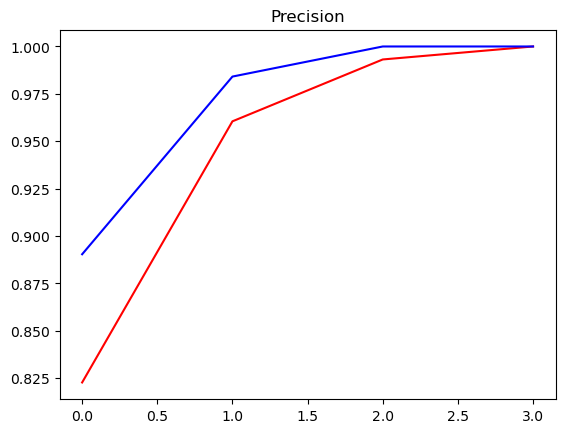

In [45]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

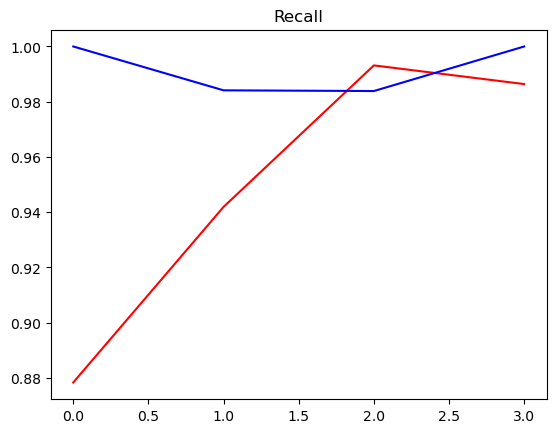

In [46]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [47]:
X_test, y_test = test.as_numpy_iterator().next()

In [48]:
yhat = model.predict(X_test)

1/1 [==============================] - 2s 2s/step


In [49]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [53]:
yhat

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]

In [54]:
y_test

array([0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.],
      dtype=float32)

In [55]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [56]:
mp3 = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/recording_00.mp3'

In [57]:
wav = load_mp3_16k_mono(mp3)

In [58]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [59]:
samples, index = audio_slices.as_numpy_iterator().next()

In [61]:
len(audio_slices)

60

In [60]:
samples.shape

(1, 48000)

In [62]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [64]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [71]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.99 else 0 for prediction in yhat]

1/1 [==============================] - 5s 5s/step


In [ ]:
yhat

In [68]:
from itertools import groupby

In [73]:
yhat = [key for key, group in groupby(yhat)]

In [74]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [75]:
calls = tf.math.reduce_sum(yhat).numpy()

In [76]:
calls

5

In [80]:
forest_recording = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/'

In [81]:
forest_recording

'/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/'

In [82]:
forest_recording = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Forest Recordings/'
results = {}
for file in os.listdir(forest_recording):
    FILEPATH = os.path.join(forest_recording, file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

1/1 [==============================] - 5s 5s/step


In [ ]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [85]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_76.mp3': 0,
 'recording_62.mp3': 0,
 'recording_48.mp3': 4,
 'recording_44.mp3': 1,
 'recording_45.mp3': 3,
 'recording_06.mp3': 5,
 'recording_43.mp3': 5,
 'recording_68.mp3': 1,
 'recording_95.mp3': 5,
 'recording_17.mp3': 3,
 'recording_65.mp3': 5,
 'recording_74.mp3': 3,
 'recording_10.mp3': 5,
 'recording_49.mp3': 0,
 'recording_15.mp3': 2,
 'recording_37.mp3': 3,
 'recording_64.mp3': 3,
 'recording_39.mp3': 1,
 'recording_04.mp3': 4,
 'recording_28.mp3': 2,
 'recording_05.mp3': 0,
 'recording_80.mp3': 1,
 'recording_57.mp3': 4,
 'recording_12.mp3': 0,
 'recording_59.mp3': 3,
 'recording_67.mp3': 0,
 'recording_09.mp3': 0,
 'recording_79.mp3': 0,
 'recording_14.mp3': 0,
 'recording_63.mp3': 1,
 'recording_86.mp3': 1,
 'recording_47.mp3': 1,
 'recording_03.mp3': 0,
 'recording_33.mp3': 0,
 'recording_08.mp3': 25,
 'recording_51.mp3': 3,
 'recording_35.mp3': 0,
 'recording_81.mp3': 5,
 'recording_30.mp3': 3,
 'recording_88.mp3': 0,
 'recording_75.mp3': 1,
 'recording_46.

In [86]:
import csv

In [87]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])